# Odkrivanje enačb, 2. del: uporaba predznanja

## 1. Verjetnostne gramatike in knjižnica ProGED
1.1 Za odkrivanje enačb z verjetnostnimi gramatikami bomo uporabili knjižnico ProGED: https://github.com/brencej/ProGED.
Instaliramo jo z ukazom "pip install git+https://github.com/brencej/ProGED". Če se pojavijo težave, ustvari sveže Pythonovo okolje in poskusi instalirati tja.

Poglej si enostaven primer uporabe spodaj. Lahko se poigraš z različnimi nastavitvami in možnostmi. Celoten nabor modelov si lahko ogledaš v "ED.models". 

In [2]:
import numpy as np
import pandas as pd

import ProGED as pg

from vajeED_2_podatki import *

In [3]:
podatki = generiraj_newton(100)

np.random.seed(1)
ED = pg.EqDisco(data=podatki, 
                lhs_vars=["F"],
                rhs_vars=["m", "a"],
                sample_size=10)

ED.generate_models()
ED.fit_models()
ED.get_results()

ModelBox: 1 models
-> [0.999999997446936*a*m], p = 0.00023040000000000002, parse trees = 1, valid = True, error = 9.851219776892273e-10, time = 0.09531188011169434

1.2 Prostor možnih enačb, ki ga želimo preiskovati, definiramo z verjetnostno kontekstno-neodvisno gramatiko. ProGED-u jo podamo v obliki stringa, zapisanega po pravilih knjižnice NLTK:

- produkcijska pravila so oblike "A -> B1 ... Bn [p]", kjer je A neterminal, B1 ... Bn so terminali ali neterminali, p pa je verjetnost pravila
- verjetnosti pravil z istim neterminalom na levi strani se morajo sešteti v 1
- krajši zapis pravil z istim neterminalom na levi strani je "A -> B1 ... Bn [p] | D1 ... Dn [q] | ... " 
- terminalni simboli se označijo z enojnimi narekovaji, npr. "A -> B 'x'"
- v ProGED-u je terminalni simbol "C" poseben - označuje numerične konstante, katerih vrednosti iščemo z optimizacijo

Gramatika za linearne izraze dveh spremenljivk je

E -> E + V | V  
V -> 'x' | 'y'

Uporabi to gramatiko za odkrivanje enačbe $y = x_1 + 3x_2$. Podatke lahko generiraš z "generiraj_linearno". Koraki:
1. zapiši linearno gramatiko v formalizmu NLTK (ne pozabi da so tudi aritmetični operatorji terminalni simboli)
2. naredi ProGED-ov objekt GeneratorGrammar, ki kot argument sprejme string iz točke 1
3. gramatiko iz točke 2 podaj ProGED-ovemu EqDisco kot argument generator
4. generiraj 15 naključnih izrazov z ED.generate_models in si jih oglej
5. kliči še fit\_models in get\_results ter si oglej rezultate

In [4]:
podatki = generiraj_linearno(100)

grammar = "E -> E '+' V [0.6] | V [0.4]\n"
grammar += "V -> 'x1' [0.33] | 'x2' [0.67]"

grammar = pg.GeneratorGrammar(grammar)
ED = pg.EqDisco(data=podatki, 
                lhs_vars=["y"],
                rhs_vars=["x1", "x2"],
                sample_size=15,
                generator=grammar)

ED.generate_models()

ModelBox: 7 models
-> [x1], p = 0.264, parse trees = 4, valid = False
-> [2*x1 + 4*x2], p = 0.0006825639291989762, parse trees = 4, valid = False
-> [x2], p = 0.536, parse trees = 4, valid = False
-> [2*x1], p = 0.026136000000000003, parse trees = 4, valid = False
-> [x1 + 3*x2], p = 0.017150709312000002, parse trees = 4, valid = False
-> [x1 + 2*x2], p = 0.021331727999999998, parse trees = 4, valid = False
-> [x1 + 4*x2], p = 0.0034472925717120005, parse trees = 4, valid = False

In [5]:
ED.fit_models()
ED.get_results()

ModelBox: 1 models
-> [x1 + 3*x2], p = 0.017150709312000002, parse trees = 4, valid = True, error = 0.0, time = 0

Zdaj linearni gramatiki dodaj še numerično konstanto. Kako se spremenijo generirani modeli in rezultati?

In [6]:
podatki = generiraj_linearno(100)

grammar = "E -> E '+' 'C' '*' V [0.6] | 'C' '*' V [0.4]\n"
grammar += "V -> 'x1' [0.33] | 'x2' [0.67]"

grammar = pg.GeneratorGrammar(grammar)
ED = pg.EqDisco(data=podatki, 
                lhs_vars=["y"],
                rhs_vars=["x1", "x2"],
                sample_size=15,
                generator=grammar)

ED.generate_models()

ModelBox: 3 models
-> [C0*x1], p = 0.158136, parse trees = 8, valid = False
-> [C0*x1 + C1*x2], p = 0.0264769407936, parse trees = 8, valid = False
-> [C0*x2], p = 0.31130987200000004, parse trees = 8, valid = False

In [7]:
ED.fit_models()
ED.get_results()

ModelBox: 1 models
-> [0.999999993198745*x1 + 2.99999999957024*x2], p = 0.0264769407936, parse trees = 8, valid = True, error = 4.246193543613293e-09, time = 0.41925668716430664

1.3. Napiši gramatiko, ki generira polinome, in jo uporabi za odkrivanje energijskega zakona. Verjetno bo potrebno zgenerirati nekaj sto modelov. Če bo imel ProGED težave z generiranjem toliko unikatnih izrazov, mu lahko daš več poskusov za generiranje z nastavitvijo "strategy_settings = {"max_repeat":1000}." 

Na prejšnjih vajah smo videli, da je šum velik trn v peti odkrivanja enačb. Kako vpliva šum na odkrivanje enačb z verjetnostnimi gramatikami?

In [8]:
podatki = generiraj_energijski_zakon(500, sum=0.1)

grammar = "P -> P '+' M [0.3] | M [0.7]\n"
grammar += "M -> M '*' F [0.5] | 'C' '*' F [0.5]\n"
grammar += "F -> 'm' [0.4] | 'h' [0.3] | 'v' [0.3]"

np.random.seed(1)
grammar = pg.GeneratorGrammar(grammar)
ED = pg.EqDisco(data=podatki, 
                sample_size=500,
                lhs_vars=["E"],
                rhs_vars=["m", "h", "v"],
                strategy_settings = {"max_repeat":1000},
                generator = grammar)

In [9]:
ED.generate_models()


ModelBox: 500 models
-> [C0*m], p = 0.288904, parse trees = 409, valid = False
-> [C0*h**2 + C1*h*m + C2*m**2 + C3*v], p = 7.6545e-08, parse trees = 409, valid = False
-> [C0*h**2*m + C1*h*m + C2*v**2 + C3*v], p = 8.611312499999997e-09, parse trees = 409, valid = False
-> [C0*h**3*m**2 + C1*h], p = 4.2524999999999995e-06, parse trees = 409, valid = False
-> [C0*v], p = 0.214725, parse trees = 409, valid = False
-> [C0*m**2*v], p = 0.016800000000000002, parse trees = 409, valid = False
-> [C0*h**2], p = 0.0158563125, parse trees = 409, valid = False
-> [C0*m + C1*v], p = 0.014301765449999998, parse trees = 409, valid = False
-> [C0*h*v + C1*h + C2*m*v + C3*m], p = 3.8272499999999995e-07, parse trees = 409, valid = False
-> [C0*h*m*v + C1*h*m + C2*m**2*v + C3*m + C4*v], p = 7.440173999999997e-14, parse trees = 409, valid = False
-> [C0*h**2*m], p = 0.012599999999999998, parse trees = 409, valid = False
-> [C0*m + C1*v**2 + C2*v], p = 4.2525e-05, parse trees = 409, valid = False
-> [C0*h*

In [10]:
ED.fit_models()
ED.get_results(3)

Model skipped. More model parameters than allowed (check max constant).
Model skipped. More model parameters than allowed (check max constant).


ModelBox: 3 models
-> [9.69406245577145*h*m + 0.370776247798963*m*v**2 + 0.220166975692208*m*v], p = 2.2963499999999986e-09, parse trees = 409, valid = True, error = 0.33663297832882544, time = 0.24361562728881836
-> [9.71921815993034*h*m - 0.09671603231358*m**2 + 0.585980869968125*m*v], p = 2.2679999999999997e-06, parse trees = 409, valid = True, error = 0.3366689070182418, time = 0.1836531162261963
-> [-0.0150252222084529*h*m*v + 9.74138677532116*h*m + 0.606994926494645*m**2*v - 0.0886952816304229*m + 0.0838822888886339*v], p = 7.440173999999997e-14, parse trees = 409, valid = True, error = 0.33674170466151815, time = 0.5974762439727783

1.4. Loti se še naslednjih enačb:
1. projekcija na y os pri kroženju $y = r\sin(\omega t)$, kjer je konstanta (*generiraj_krozenje*).  
2. Lorenzov popravek $\gamma = \sqrt{1 - v^2/c^2}$, kjer je c hitrost svetlobe, približno $3\cdot10^8 m/s$ (*generiraj_lorenz*)
3. ploščina pravilnega n-kotnika: $p = na^2/(4 \tan(\pi/n))$ (*generiraj_ploscina*)

Za vsako od enačb napiši gramatiko, ki jo lahko odkrije. Premisli tudi, kakšne verjetnosti produkcij bi bile smiselne. Poskusi čim bolj omejiti prostor enačb, pri čemer naj ima gramatika še vedno vsaj eno rekurzivno pravilo. Gramatike lahko preizkusiš tudi na podatkih, ampak se zavedaj, da bosta enačbi 2 in 3 verjetno preveč kompleksni, da bi jih imeli čas odkriti na vajah.


In [11]:
gramatika1 = "E -> E '*' F [0.4] | F [0.6] \n"
gramatika1 += "F -> V [0.6] | T '(' M ')' [0.4] \n"
gramatika1 += "T -> 'sin' [0.4] | 'cos' [0.4] | 'tan' [0.2] \n"
gramatika1 += "M -> M '*' V [0.4] | V [0.6] \n"
gramatika1 += "V -> 'r' [0.4] | 't' [0.4] | 'C' [0.2]"
gramatika1 = pg.GeneratorGrammar(gramatika1)

podatki = generiraj_krozenje(100)
ED = pg.EqDisco(data=podatki, 
                sample_size=50,
                lhs_vars=["y"],
                rhs_vars=["r", "t"],
                generator = gramatika1)
ED.generate_models()

ModelBox: 30 models
-> [r], p = 0.288, parse trees = 414, valid = False
-> [C0*r*cos(t)], p = 0.00010616832000000001, parse trees = 414, valid = False
-> [sin(t)], p = 0.04608, parse trees = 414, valid = False
-> [r*tan(t)], p = 0.00110592, parse trees = 414, valid = False
-> [cos(C0*r*t)*tan(r)], p = 2.264924160000001e-06, parse trees = 414, valid = False
-> [r*t], p = 0.041471999999999995, parse trees = 414, valid = False
-> [t*cos(t)], p = 0.00221184, parse trees = 414, valid = False
-> [t], p = 0.288, parse trees = 414, valid = False
-> [t*cos(r)], p = 0.00221184, parse trees = 414, valid = False
-> [cos(r)], p = 0.02304, parse trees = 414, valid = False
-> [t*sin(C0*r)], p = 0.00017694720000000007, parse trees = 414, valid = False
-> [C0*cos(C1*t)], p = 1.4155776000000007e-05, parse trees = 414, valid = False
-> [sin(r)], p = 0.02304, parse trees = 414, valid = False
-> [r*sin(r)*cos(t)], p = 3.3973862400000006e-05, parse trees = 414, valid = False
-> [t**2], p = 0.013824, parse t

In [12]:
gramatika2 = "E -> E '+' F [0.2] | E '-' F [0.2] | F [0.6] \n"
gramatika2 += "F -> F '*' T [0.2] | F '/' T [0.2] | T [0.6] \n"
gramatika2 += "T -> R [0.3] | V [0.4] | 'C' [0.3] \n"
gramatika2 += "R -> '(' E ')' [0.3] | 'sqrt' '(' E ')' [0.3] | 'exp' '(' E ')' [0.2] | 'log' '(' E ')' [0.2]\n"
gramatika2 += "V -> 'v' [1.0]"
gramatika2 = pg.GeneratorGrammar(gramatika2)

podatki = generiraj_krozenje(100)
ED = pg.EqDisco(data=podatki, 
                sample_size=50,
                lhs_vars=["gamma"],
                rhs_vars=["v"],
                generator = gramatika2)
ED.generate_models()

ModelBox: 28 models
-> [C0*v**2], p = 8.062156800000003e-08, parse trees = 417, valid = False
-> [log(C0 + v - exp(C1*v))], p = 2.5076532510719993e-11, parse trees = 417, valid = False
-> [C0*v], p = 0.00864, parse trees = 417, valid = False
-> [v], p = 0.288, parse trees = 417, valid = False
-> [sqrt(C0*v + v)], p = 8.062156799999999e-07, parse trees = 417, valid = False
-> [C0 - sqrt(v)], p = 0.00016796159999999996, parse trees = 417, valid = False
-> [C0*v + v**2], p = 1.07495424e-06, parse trees = 417, valid = False
-> [C0*exp(C1*v*log(C2 + C3*exp(C4*exp(-v)/log(v*(C5 + v)**(1/4)*exp(C6*v)*log(C7*log(C8*sqrt(v)*sqrt(log(C20 + C9*v/log(C10*exp(C11 + C12*(C13/(C14 - sqrt(C15*v)/v) + v)/v + sqrt(C16 + C17*(C18*v + C19 + v)/sqrt(v) + 2*v)/v)))))) + exp(C21*log(v**(1/4)))) - v)/v)) + log(v)], p = 8.83069421835006e-140, parse trees = 417, valid = False
-> [C0 + v], p = 0.005184013060694015, parse trees = 417, valid = False
-> [C0/v], p = 0.00864, parse trees = 417, valid = False
-> [v/lo

## 2. Preštevanje dreves in verjetnosti

Za linearno gramatiko iz 1.2 ter vsako od gramatik iz 1.4. nariši:
1. graf števila dreves z dano višino
2. graf verjetnosti vseh dreves do vključno dane višine

Če želiš, lahko sam implementiraš rekurzivne enačbe s predavanj. Alternativno lahko uporabiš ProGED-ovi metodi "grammar.count_trees" in "grammar.count_coverage". Obema je treba podati začetni neterminalni simbol, ki mora biti objekt nltk.Nonterminal.



In [13]:
from nltk import Nonterminal
import matplotlib.pyplot as plt

grammar = "E -> E '+' V [0.6] | V [0.4]\n"
grammar += "V -> 'x1' [0.33] | 'x2' [0.67]"
grammar = pg.GeneratorGrammar(grammar)

hji = list(range(1,11))
drevesa = [grammar.count_trees(Nonterminal("E"), h) for h in range(1, 11)]
verjetnost = [grammar.count_coverage(Nonterminal("E"), h) for h in range(1, 11)]

Text(0, 0.5, 'verjetnost vseh do vklucno h')

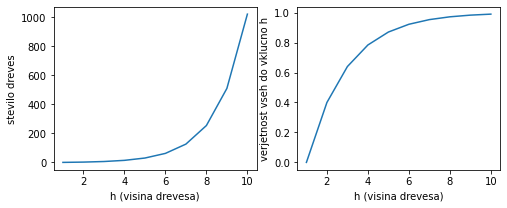

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(hji, drevesa)
ax[0].set_xlabel("h (visina drevesa)")
ax[0].set_ylabel("stevilo dreves")

ax[1].plot(hji, verjetnost)
ax[1].set_xlabel("h (visina drevesa)")
ax[1].set_ylabel("verjetnost vseh do vklucno h")

## 3. Merske enote

Upoštevanje predznanja o merskih enotah spremenljivk nam pogosto lahko močno zmanjša prostor enačb. 
ProGED nam to omogoča preko formalizma atributnih gramatik, ki jih pretvorimo v navadne konteksno-neodvisne gramatike. Za pogoste tipe gramatik ProGED že implementira njihove dimenzijsko-pravilne različice.
Enote predstavimo z vektorji v izbrani bazi osnovnih enot (recimo SI). 

3.1 Poglej si spodnji primer za Newtonov zakon ter dopolni manjkajoče!

Plonkec iz osnovne šole:
- Newtonov zakon $ F=m a$
- F je sila, z enoto kg*m/s^2
- m je masa, z enoto kg
- a je pospešek, z enoto m/s^2

In [15]:
from ProGED.generators.dimensions import construct_dimensional_polynomial_grammar

podatki = generiraj_newton(100)

spremenljivke = ["m", "a"]
simboli_enot = ["m", "s", "kg"]
enote_na_desni = [[0,0,1], [1,-2,0]] # m, kg*m/s^2
enota_na_levi = [1,-2,1]

grammar = construct_dimensional_polynomial_grammar(variables = spremenljivke,
                                        units = enote_na_desni,
                                        target_variable_unit = enota_na_levi,
                                        unit_symbols = simboli_enot)

grammar

Grammar with 24 productions (start state = P_m1s-2kg1)
    P_m1s-2kg1 -> P_m1s-2kg1 '+' M_m1s-2kg1 [0.4]
    P_m1s-2kg1 -> M_m1s-2kg1 [0.6]
    P_m0s0kg1 -> P_m0s0kg1 '+' M_m0s0kg1 [0.4]
    P_m0s0kg1 -> M_m0s0kg1 [0.6]
    P_m1s-2kg0 -> P_m1s-2kg0 '+' M_m1s-2kg0 [0.4]
    P_m1s-2kg0 -> M_m1s-2kg0 [0.6]
    P_m0s0kg0 -> P_m0s0kg0 '+' M_m0s0kg0 [0.4]
    P_m0s0kg0 -> M_m0s0kg0 [0.6]
    M_m1s-2kg1 -> M_m1s-2kg1 '*' V_m0s0kg0 [0.2]
    M_m1s-2kg1 -> M_m0s0kg0 '*' V_m1s-2kg1 [0.2]
    M_m1s-2kg1 -> M_m0s0kg1 '*' V_m1s-2kg0 [0.2]
    M_m1s-2kg1 -> M_m1s-2kg0 '*' V_m0s0kg1 [0.2]
    M_m1s-2kg1 -> V_m1s-2kg1 [0.2]
    M_m0s0kg1 -> M_m0s0kg1 '*' V_m0s0kg0 [0.333333]
    M_m0s0kg1 -> M_m0s0kg0 '*' V_m0s0kg1 [0.333333]
    M_m0s0kg1 -> V_m0s0kg1 [0.333333]
    M_m1s-2kg0 -> M_m1s-2kg0 '*' V_m0s0kg0 [0.333333]
    M_m1s-2kg0 -> M_m0s0kg0 '*' V_m1s-2kg0 [0.333333]
    M_m1s-2kg0 -> V_m1s-2kg0 [0.333333]
    M_m0s0kg0 -> M_m0s0kg0 '*' V_m0s0kg0 [0.4]
    M_m0s0kg0 -> V_m0s0kg0 [0.4]
    M_m0s0kg0 

Vidimo, da ima gramatika veliko več simbolov in produkcij, kot tiste, ki smo jih pisali na roko. Zdaj uporabimo EqDisco in zgenerirajmo množico enačb.

In [16]:
ED = pg.EqDisco(data=podatki, 
                lhs_vars=["F"],
                rhs_vars=["m", "a"],
                sample_size=10,
                generator = grammar)

ED.generate_models()


ModelBox: 2 models
-> [a*m], p = 0.12, parse trees = 419, valid = False
-> [C0*a*m], p = 0.008, parse trees = 419, valid = False

3.2. Poglejmo še pod krov, torej atributno gramatiko, ki izraža pravila za računanje z merskimi enotami. Oglej si spodnjo atributno gramatiko za dimenzijsko-pravilne polinome ter premisli, kako bi napisal dimenzijsko-pravilno atributno verzijo gramatik, ki si jih sestavil v nalogi 1.4. 

In [17]:
from ProGED.generators.dimensions import dimensional_attribute_grammar_to_pcfg
from nltk import PCFG

prods = []
prods += [["P -> P '+' M", 0.4, ["uP1 - uP2", "uP1 - uM1"]]]
prods += [["P -> M", 0.6, ["uP1 - uM1"]]]
prods += [["M -> M '*' V", 0.4, ["-uM1 + uM2 + uV1"]]]
prods += [["M -> V", 0.4, ["uM1 - uV1"]]]
prods += [["M -> 'C'", 0.2, ["uM1"]]]

pcfg_start, pcfg_prods = dimensional_attribute_grammar_to_pcfg(prods, 
                                                               spremenljivke, 
                                                               enote_na_desni, 
                                                               enota_na_levi, 
                                                               append_vars = True, 
                                                               unit_symbols = simboli_enot)
grammar = pg.GeneratorGrammar(PCFG(pcfg_start, pcfg_prods))
grammar

Grammar with 24 productions (start state = P_m1s-2kg1)
    P_m1s-2kg1 -> P_m1s-2kg1 '+' M_m1s-2kg1 [0.4]
    P_m1s-2kg1 -> M_m1s-2kg1 [0.6]
    P_m0s0kg1 -> P_m0s0kg1 '+' M_m0s0kg1 [0.4]
    P_m0s0kg1 -> M_m0s0kg1 [0.6]
    P_m1s-2kg0 -> P_m1s-2kg0 '+' M_m1s-2kg0 [0.4]
    P_m1s-2kg0 -> M_m1s-2kg0 [0.6]
    P_m0s0kg0 -> P_m0s0kg0 '+' M_m0s0kg0 [0.4]
    P_m0s0kg0 -> M_m0s0kg0 [0.6]
    M_m1s-2kg1 -> M_m1s-2kg1 '*' V_m0s0kg0 [0.2]
    M_m1s-2kg1 -> M_m0s0kg0 '*' V_m1s-2kg1 [0.2]
    M_m1s-2kg1 -> M_m0s0kg1 '*' V_m1s-2kg0 [0.2]
    M_m1s-2kg1 -> M_m1s-2kg0 '*' V_m0s0kg1 [0.2]
    M_m1s-2kg1 -> V_m1s-2kg1 [0.2]
    M_m0s0kg1 -> M_m0s0kg1 '*' V_m0s0kg0 [0.333333]
    M_m0s0kg1 -> M_m0s0kg0 '*' V_m0s0kg1 [0.333333]
    M_m0s0kg1 -> V_m0s0kg1 [0.333333]
    M_m1s-2kg0 -> M_m1s-2kg0 '*' V_m0s0kg0 [0.333333]
    M_m1s-2kg0 -> M_m0s0kg0 '*' V_m1s-2kg0 [0.333333]
    M_m1s-2kg0 -> V_m1s-2kg0 [0.333333]
    M_m0s0kg0 -> M_m0s0kg0 '*' V_m0s0kg0 [0.4]
    M_m0s0kg0 -> V_m0s0kg0 [0.4]
    M_m0s0kg0 